# Import Packages

In [1]:
from eurostatapiclient import EurostatAPIClient
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
sns.set()

# Get EU GDP Data

In [2]:
VERSION = 'v2.1'
FORMAT = 'json'
LANGUAGE = 'en'
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

In [3]:
params = {'unit': 'CLV10_MEUR', 'na_item': 'B1GQ', 'geo': 'EA', 's_adj': 'SCA'}
filtered_dataset = client.get_dataset('namq_10_gdp', params=params)
filtered_dataframe = filtered_dataset.to_dataframe()
filtered_dataframe.head()

,values,unit,s_adj,na_item,geo,time
0,NaN,CLV10_MEUR,SCA,B1GQ,EA,1975Q1
1,NaN,CLV10_MEUR,SCA,B1GQ,EA,1975Q2
2,NaN,CLV10_MEUR,SCA,B1GQ,EA,1975Q3
3,NaN,CLV10_MEUR,SCA,B1GQ,EA,1975Q4
4,NaN,CLV10_MEUR,SCA,B1GQ,EA,1976Q1


In [4]:
dfEU_GDP = filtered_dataframe[['values', 'time']].dropna()
dfEU_GDP.columns = ['GDP', 'Date']
dfEU_GDP.index = dfEU_GDP['Date']
dfEU_GDP = dfEU_GDP.drop('Date', axis=1)
dfEU_GDP.head() 

,GDP
Date,
1995Q1,1768557.1
1995Q2,1778159.1
1995Q3,1782293.6
1995Q4,1788868.7
1996Q1,1790962.0


# Transform GDP to Growth Rate

In [5]:
# Multiply by 400 to obtain annualized growth rate from quarterly data
dfEU_Growth = pd.DataFrame(((np.log(dfEU_GDP['GDP']).diff())*400).dropna())
dfEU_Growth.columns = ['Growth']
dfEU_Growth.index = pd.PeriodIndex(dfEU_Growth.index, freq='Q')
dfEU_Growth.head()

,Growth
Date,
1995Q2,2.165840
1995Q3,0.928983
1995Q4,1.472934
1996Q1,0.467799
1996Q2,3.111440


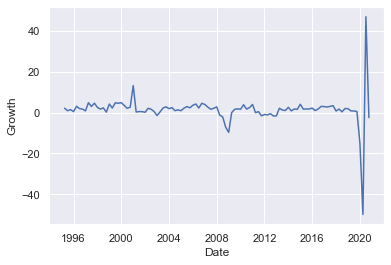

In [6]:
sns.lineplot(x=dfEU_Growth.index.to_timestamp(), y=dfEU_Growth['Growth']);

In [7]:
# Remove outliers due to COVID-19
dfEU_Growth = dfEU_Growth.loc[dfEU_Growth.index < '2020Q1']
dfEU_Growth.tail()

,Growth
Date,
2018Q4,2.018157
2019Q1,1.892040
2019Q2,0.826247
2019Q3,0.801331
2019Q4,0.544432


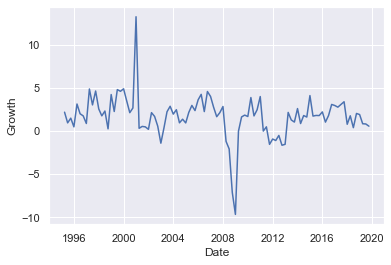

In [8]:
sns.lineplot(x=dfEU_Growth.index.to_timestamp(), y=dfEU_Growth['Growth']);

# Time Series Analysis

In [9]:
# Test Stationarity
adfuller(dfEU_Growth)

(-5.935441401308848,
 2.3269081222850387e-07,
 0,
 98,
 {'1%': -3.4989097606014496,
  '5%': -2.891516256916761,
  '10%': -2.5827604414827157},
 386.0558499166743)

The null hypothesis that a unit root is present in a time series is rejected, therefore the series is stationary.

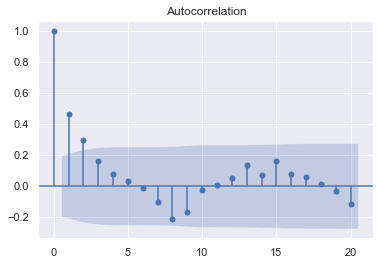

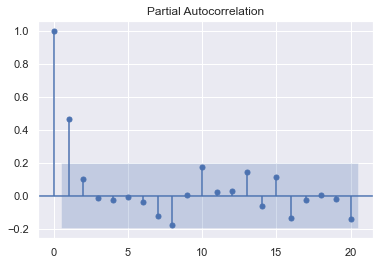

In [10]:
# Autocovariance and Partial Autocovariance
plot_acf(dfEU_Growth), plot_pacf(dfEU_Growth);

The autocovariance and partial autocovariance functions (ACF/PACF) can be used to determine the order of the ARIMA process. The decaying ACF and the significant first lag of the PACF suggest that the process is an AR(1). To consolidate this result I look at the Bayesian information criterion (BIC) of an ARIMA(1,0,0), ARIMA(0,0,1), and ARIMA(1,0,1).

In [11]:
mod=ARIMA(dfEU_Growth, order=(1,0,0)).fit()
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:                 Growth   No. Observations:                   99
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -215.967
Date:                Tue, 16 Feb 2021   AIC                            437.934
Time:                        21:48:01   BIC                            445.719
Sample:                    06-30-1995   HQIC                           441.084
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6785      0.402      4.173      0.000       0.890       2.467
ar.L1          0.4577      0.041     11.195      0.000       0.378       0.538
sigma2         4.5846      0.292     15.710      0.0

In [12]:
mod=ARIMA(dfEU_Growth, order=(0,0,1)).fit()
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:                 Growth   No. Observations:                   99
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -219.124
Date:                Tue, 16 Feb 2021   AIC                            444.249
Time:                        21:48:01   BIC                            452.034
Sample:                    06-30-1995   HQIC                           447.399
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6837      0.307      5.492      0.000       1.083       2.285
ma.L1          0.3575      0.058      6.182      0.000       0.244       0.471
sigma2         4.8915      0.325     15.066      0.0

In [13]:
mod=ARIMA(dfEU_Growth, order=(1,0,1)).fit()
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:                 Growth   No. Observations:                   99
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -215.517
Date:                Tue, 16 Feb 2021   AIC                            439.034
Time:                        21:48:01   BIC                            449.414
Sample:                    06-30-1995   HQIC                           443.234
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6735      0.459      3.642      0.000       0.773       2.574
ar.L1          0.6058      0.215      2.820      0.005       0.185       1.027
ma.L1         -0.1885      0.254     -0.742      0.4

I choose the ARIMA(1,0,0) specification based on the BIC.

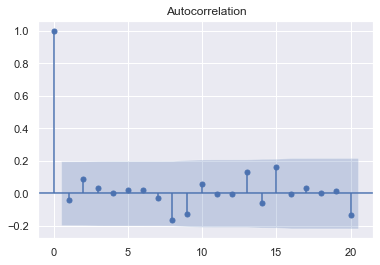

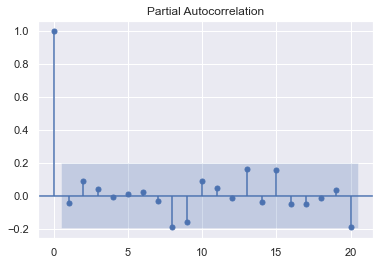

In [14]:
mod=ARIMA(dfEU_Growth.dropna(), order=(1,0,0)).fit()
plot_acf(mod.resid), plot_pacf(mod.resid);

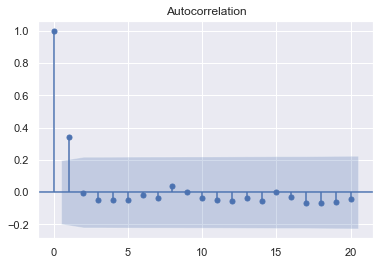

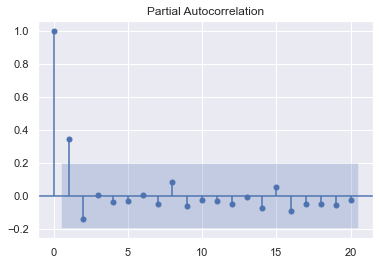

In [15]:
plot_acf(mod.resid**2), plot_pacf(mod.resid**2);

The residuals and the squared residuals are white noise. Significant lags in the squared residuals would have indicated the need for an ARCH/GARCH extension to the model.

In [16]:
# Save DataFrame
dfEU_Growth.to_pickle('EU_Growth.pkl')